In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
from numpy.random import default_rng
import risktools as rt
from time import time
from numpy.random import default_rng, Generator, SFC64
from numba import njit


In [9]:
s0 = 5
mu = 4
theta = 8
dt = 0.25
T = 4
sigma = 0.32


mu = np.ones((252, 100)) * 4
mu[100:, :50] = 8

df = rt.simOU(
    s0,
    mu,
    theta,
    sigma,
    T=1,
    dt=1 / 252,
    sims=100,
    seed=12345,
    log_price=False,
    c=False,
)

Half-life of theta in days =  21.834136187638276


In [31]:
mu = rt.stochastic_mu(4, 0.5, 4, 1 / 252, 100, 2520, 100, seed=12345)

TypeError: stochastic_mu() got multiple values for argument 'seed'

In [29]:
mu

array([[4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       ...,
       [4., 4., 4., ..., 8., 4., 4.],
       [4., 4., 4., ..., 8., 4., 4.],
       [4., 4., 4., ..., 8., 4., 4.]])

<AxesSubplot: >

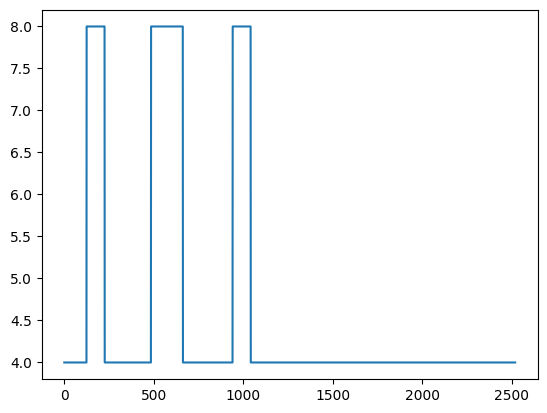

In [30]:
pd.DataFrame(mu).iloc[:,99].plot()

<AxesSubplot: >

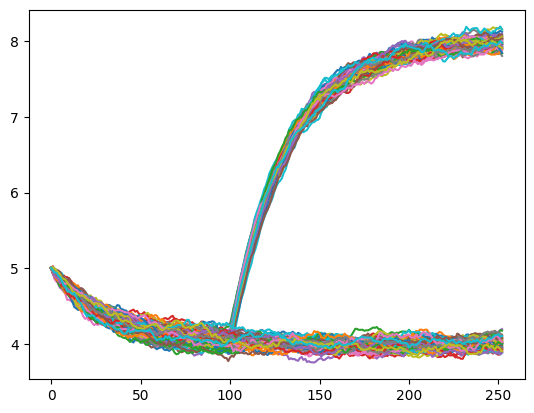

In [10]:
df.plot(legend=False)

In [ ]:

jump_avgsize = 1
jump_stdv = 0.32
sims = 20
jump_prob = 1
dt = 0.25

elp = pd.Series(
    np.random.lognormal(mean=np.log(jump_avgsize), sigma=jump_stdv, size=sims)
)
jp = pd.Series(np.random.poisson(lam=jump_prob * dt, size=sims))

rng = Generator(SFC64())

In [12]:
from numba import njit, objmode
import random

@njit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [13]:
monte_carlo_pi(100)

3.44

In [23]:
@njit()
def tester(rng, N):
    with objmode(tf="float64[:]"):
        tf = rng.lognormal(size=N)
    return tf

In [24]:
%%timeit -n1 -r5
tf = tester(rng, N=2520*10000)

418 ms ± 62.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [33]:
%%timeit -n1 -r5
tf = np.ascontiguousarray(rng.lognormal(mean=np.log(jump_avgsize), sigma=jump_stdv, size=(2520, 10000)))

398 ms ± 10.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [38]:
%%timeit -n1 -r5
tf = rng.lognormal(mean=np.log(jump_avgsize), sigma=jump_stdv, size=(2520,10000))

396 ms ± 12.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [52]:
%%timeit -n1 -r1
tf.T.reshape((2520)*10000)

7.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [36]:
tf.flags['C_CONTIGUOUS']

True

In [4]:
%%prun -s cumulative -l 10 -T prun0
rt.simOUJ(s0=5, mu=4, theta=20, T=10, dt=1/252, jump_avgsize=3.0, c=True, mr_lag=10, sims=10000)#.iloc[:,:100].plot(legend=False)

print(open('prun0', 'r').read())

Half-life of theta in days =  8.73365447505531
         292 function calls (280 primitive calls) in 1.653 seconds

   Ordered by: cumulative time
   List reduced from 113 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.653    1.653 {built-in method builtins.exec}
        1    0.002    0.002    1.653    1.653 <string>:1(<module>)
        1    0.004    0.004    1.652    1.652 _sims.py:304(simOUJ)
        1    0.000    0.000    0.470    0.470 _sims.py:451(_simOUJc)
        1    0.412    0.412    0.412    0.412 {method 'lognormal' of 'numpy.random._generator.Generator' objects}
        1    0.307    0.307    0.307    0.307 {method 'normal' of 'numpy.random._generator.Generator' objects}
        1    0.275    0.275    0.275    0.275 {method 'poisson' of 'numpy.random._generator.Generator' objects}
        1    0.215    0.215    0.215    0.215 {extensions.csimOUJ}
        8    0.188    0.024    0.188    0

         320 function calls (310 primitive calls) in 1.636 seconds

   Ordered by: cumulative time
   List reduced from 118 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.636    1.636 {built-in method builtins.exec}
        1    0.002    0.002    1.636    1.636 <string>:1(<module>)
        1    0.004    0.004    1.634    1.634 _sims.py:304(simOUJ)
        1    0.000    0.000    0.476    0.476 _sims.py:451(_simOUJc)
        1    0.403    0.403    0.403    0.403 {method 'lognormal' of 'numpy.random._generator.Generator' objects}
        1    0.303    0.303    0.303    0.303 {method 'normal' of 'numpy.random._generator.Generator' objects}
        1    0.259    0.259    0.259    0.259 {method 'poisson' of 'numpy.random._generator.Generator' objects}
        1    0.212    0.212    0.212    0.212 {extensions.csimOUJ}
        8    0.197    0.025    0.197    0.025 {method 'reshape' of 'numpy.ndarray' objec

In [2]:
%%timeit -n1 -r3
rt.simOUJ(s0=5, mu=4, theta=20, T=10, dt=1/252, jump_avgsize=3.0, c=False, mr_lag=10, sims=10000)#.iloc[:,:100].plot(legend=False)

Half-life of theta in days =  8.73365447505531
Half-life of theta in days =  8.73365447505531
Half-life of theta in days =  8.73365447505531
8.3 s ± 99.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [26]:
%%timeit -n1 -r3
rt.simOUJ(s0=5, mu=4, theta=20, T=10, dt=1/252, jump_avgsize=3.0, c=True, mr_lag=10, sims=10000)#.iloc[:,:100].plot(legend=False)

Half-life of theta in days =  8.73365447505531
Half-life of theta in days =  8.73365447505531
Half-life of theta in days =  8.73365447505531
1.58 s ± 64.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Half-life of theta in days =  17.46730895011062


<AxesSubplot: >

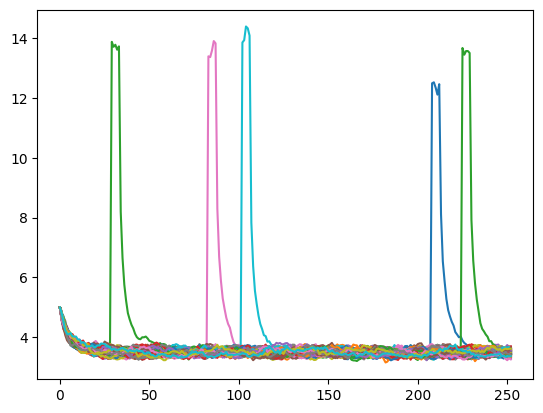

In [4]:
rt.simOUJ(s0=5, mu=4, theta=10, T=1, dt=1/252, jump_avgsize=10.0, c=True, mr_lag=5, sims=1000, seed=54321).iloc[:,:100].plot(legend=False)

Half-life of theta in days =  17.46730895011062


<AxesSubplot: >

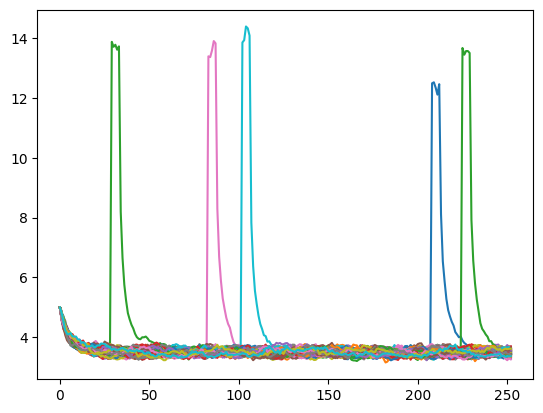

In [5]:
rt.simOUJ(s0=5, mu=4, theta=10, T=1, dt=1/252, jump_avgsize=10.0, c=False, mr_lag=5, sims=1000, seed=54321).iloc[:,:100].plot(legend=False)

In [6]:
eps = np.array([0.1,-0.2,0.5,0.3,-0.4,-0.3,0.2,0.1,-0.2,0.5,0.3,-0.4,-0.3,0.2,0.1,0.5])
eps = np.c_[eps, eps]

In [7]:
eps.shape

(16, 2)

In [8]:
elp = np.ones(eps.shape)

In [9]:
ejp = np.zeros(eps.shape)

In [10]:
ejp[5,:] = 1

In [11]:
rt.simOUJ(T=4, s0=5, mu=4, theta=2, dt=0.25, sigma=0.32, jump_avgsize=1, jump_prob=0.1, jump_stdv=0.32, eps=eps, elp=elp, ejp=ejp, sims=2)

Half-life of theta in days =  87.3365447505531


,0,1
0,5.000000,5.000000
1,2.330000,2.330000
2,4.084490,4.084490
3,4.034475,4.034475
4,3.956861,3.956861
5,3.591126,3.591126
6,4.973355,4.973355
7,2.463415,2.463415
8,4.272282,4.272282
9,3.340322,3.340322


In [12]:
sigma = np.ones((252, sims)) * 0.1

In [13]:
sigma[100:,:] = 0.5

In [16]:
ss = rt.simOUJ(sigma=sigma, theta=20, T=1, dt=1/252, sims=sims, seed=12345, mr_lag=20)#.iloc[:,:100].plot(legend=False)

Half-life of theta in days =  8.73365447505531


<AxesSubplot: >

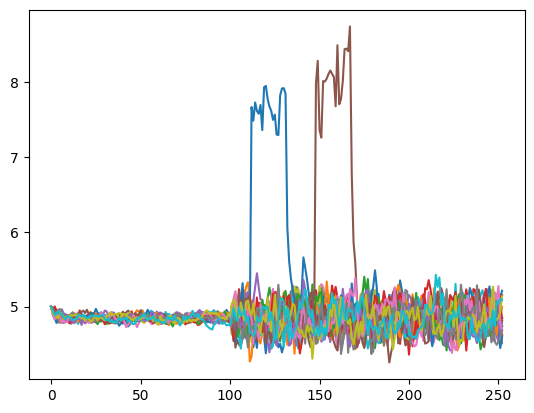

In [17]:
ss.iloc[:,:100].plot(legend=False)

In [127]:
ss.iloc[152,:].std()/ss.iloc[25,:].std() > 3

True